# Assignment 1


In [2]:
import numpy as np
np.random.seed(13) #TODO Check if this is used for sgd
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Reshape, Lambda
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import model_to_dot
from keras.preprocessing import sequence
from gensim.models import KeyedVectors
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors as nn
from matplotlib import pylab
from __future__ import division
import matplotlib.pyplot as plt

/home/mathyn/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# DO NOT Modify the lines in this cell
path = 'alice.txt'
corpus = open(path).readlines()[0:700]

corpus = [sentence for sentence in corpus if sentence.count(" ") >= 2]

tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'+"'")
tokenizer.fit_on_texts(corpus)
corpus = tokenizer.texts_to_sequences(corpus)
nb_samples = sum(len(s) for s in corpus)
V = len(tokenizer.word_index) + 1

# Is this something they need to change?
dim = 100
dim_50 = 50
dim_150 = 150
dim_300 = 300
window_size = 2 #use this window size for Skipgram, CBOW, and the model with the additional hidden layer
window_size_corpus = 4 #use this window size for the co-occurrence matrix

## Question 1

### Co-occurrence Matrix
Use the provided code to load the "Alice in Wonderland" text document. 
1. Implement the word-word co-occurrence matrix for “Alice in Wonderland”
2. Normalize the words such that every value lies within a range of 0 and 1
3. Compute the cosine distance between the given words:
    - Alice 
    - Dinah
    - Rabbit
4. List the 5 closest words to 'Alice'. Discuss the results.
5. Discuss what the main drawbacks are of a term-term co-occurence matrix solutions?


In [3]:
# create inverted index to help recover the words from indexes
inverted_index = {}
for word, i in tokenizer.word_index.items():
    inverted_index[i] = word
    
#print(inverted_index)

### Word-word co-ocurrence matrix and normalization

In [4]:
#create co-occurrence matrix
#print(corpus[0])
coMatrix = np.zeros((V, V))
total = 0
for sequence in corpus:
    for idx, termId in enumerate(sequence):
        sl = len(sequence)
        ## select left window
        leftw = sequence[max(idx - window_size_corpus, 0): idx]
        ## select right window
        rightw = sequence[idx + 1: min(idx + window_size_corpus + 1, sl)]
        # update co-occurrence matrix
        neighboors = leftw + rightw
        for neighbor in neighboors: 
            coMatrix[termId, neighbor] += 1
            total += 1
        

# matrix normalization over the total number of the frequencies in the matrix
# as recommended in class
(rows, columns) = coMatrix.shape
for rowIdx in range(rows):
    # ignore first row with 0 entries everywhere
    if (rowIdx > 0):
        row = coMatrix[rowIdx]
        #total = row.sum()
        # avoid division by zero in words that have no neighboors
        if total > 0:
            coMatrix[rowIdx] = np.divide(row, total)


In [5]:
print(coMatrix)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.10132159e-03 1.69986593e-03 ... 2.39417736e-05
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.69986593e-03 4.30951925e-04 ... 2.39417736e-05
  2.39417736e-05 2.39417736e-05]
 ...
 [0.00000000e+00 2.39417736e-05 2.39417736e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.39417736e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.39417736e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


In [6]:
#find cosine similarity to Alice, Dinah and Rabbit
aliceIdx = tokenizer.word_index['Alice'.lower()]
dinahIdx = tokenizer.word_index['Dinah'.lower()]
rabbitIdx = tokenizer.word_index['Rabbit'.lower()]

aliceVector = coMatrix[aliceIdx].reshape(1, -1)
dinahVector = coMatrix[dinahIdx].reshape(1, -1)
rabbitVector = coMatrix[rabbitIdx].reshape(1, -1)
print(aliceVector)
print(dinahVector)
print(rabbitVector)

cosAD = cosine_similarity(aliceVector, dinahVector)
print("Cosine similarity between Alice and Dinah: {}".format(cosAD))
cosAR = cosine_similarity(aliceVector, rabbitVector)
print("Cosine similarity between Alice and Rabbit: {}".format(cosAR))
cosDR = cosine_similarity(dinahVector, rabbitVector)
print("Cosine similarity between Dinah and Rabbit: {}".format(cosDR))


[[0.         0.00033518 0.00043095 ... 0.         0.         0.        ]]
[[0.00000000e+00 7.18253208e-05 7.18253208e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
[[0.00000000e+00 3.83068378e-04 2.39417736e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
Cosine similarity between Alice and Dinah: [[0.39360011]]
Cosine similarity between Alice and Rabbit: [[0.47890931]]
Cosine similarity between Dinah and Rabbit: [[0.29862324]]


### Five closest words to Alice

In [7]:
#find the closest words to Alice
nbrs = nn(n_neighbors=6, algorithm='brute', metric='cosine').fit(coMatrix)
distances, indices = nbrs.kneighbors(aliceVector)

print("Closest words to Alice")
for pos, index in enumerate(indices[0]):
    print("{}: {}".format(pos, inverted_index[index]))

Closest words to Alice
0: alice
1: she
2: it
3: the
4: a
5: herself


From the results above we observe the six closest words to 'Alice'.

* The first word corresponds to 'Alice' itself. This word is returned by the NearestNeighbors classifier from sklearn by default. 

* The next five words are the closest words to 'Alice'.

In [8]:
#Save your all the vector representations of your word embeddings in this way
#Change when necessary the sizes of the vocabulary/embedding dimension

f = open('vectors_co_occurrence.txt',"w")
f.write(" ".join([str(V-1),str(V-1)]))
f.write("\n")

#vectors = your word co-occurrence matrix
vectors = []
for word, i in tokenizer.word_index.items():    
    f.write(word)
    f.write(" ")
    f.write(" ".join(map(str, list(coMatrix[i,:]))))
    f.write("\n")
f.close()

In [9]:
#reopen your file as follows

#co_occurrence = KeyedVectors.load_word2vec_format('./vectors_co_occurrence.txt', binary=False)

### Discussion of the drawbacks: 

One drawback of the co-occurrence matrix it's its size. It has a size of |V| x |V|, where |V| corresponds to the number of different words in the computed vocabulary (after preprocessing operations like stopwords removal, stemming, etc. are applied to the input dataset). For the Alice dataset used on this assigment, the size of |V| is 1182, and the obtained co-ocurrence matrix needs 6mb to be stored. The size of our vocabulary is very small in comparison with other vocabularies used in real world applications. Those vocabularies have more than ten thousand words, hundred thousand words, or one million words. For such vocabularies, a huge amount of memory is needed to store the corresponding co-occurrence matrix.

Also, this matrix is very sparse, most of its entries contain zeros because most of the words in the vocabulary are not associated to the rest of the words. Hence, another representation could be used to avoid wasting memory.

By construction, this matrix allows frequent words to be represented by more populated vectors. Therefore, when computing the 'n' most similar words for each vector, these words are more likely to appear in the results than the non frequent words. This becomes a problem when these type of words don't present meaningful information for the final user, like when these words can be considered as stopwords. Weighting techniques like PPMI and tf-idf can be applied to the co-occurrence matrix to solve this issue. 

## Question 2

### Word embeddings
Build embeddings with a keras implementation where the embedding vector is of length 50, 150 and 300. Use the Alice in Wonderland text book for training.
1. Using the CBOW model
2. Using Skipgram model
3. Add extra hidden dense layer to CBow and Skipgram implementations. Choose an activation function for that layer and justify your answer.
4. Analyze the four different word embeddings
    - Implement your own function to perform the analogy task with. Do not use existing libraries for this task such as Gensim. Your function should be able to answer whether an anaology as in the example given in the pdf-file is true.
    - Compare the performance on the analogy task between the word embeddings that you have trained in 2.1, 2.2 and 2.3.  
    - Visualize your results and interpret your results
5. Use the word co-occurence matrix from Question 1. Compare the performance on the analogy task with the performance of your trained word embeddings.  
6. Discuss:
    - What are the main advantages of CBOW and Skipgram?
    - What is the advantage of negative sampling?
    - What are the main drawbacks of CBOW and Skipgram?
7. Load pre-trained embeddings on large corpuses (see the pdf file). You only have to consider the word embeddings with an embedding size of 300
    - Compare performance on the analogy task with your own trained embeddings from "Alice in Wonderland". You can limit yourself to the vocabulary of Alice in Wonderland. Visualize the pre-trained word embeddings and compare these with the results of your own trained word embeddings. 


### Train CBOW models

In [6]:
# prepare data for cbow

from typing import Tuple


def generate_data_cbow(corupus: list, window_size: int=2) -> Tuple[np.ndarray, np.ndarray]:
    """
    Create CBOW based on a corpus.
    Loop through the sentences and create bag of words based on the windows size.
    Args:
        corpus: list with words, split up by sentences in a nested list
        window_size: size of the bag (1 = one word after and one word before)
    """
    
    for sentence in corpus:
        for x in range(0, len(sentence) - window_size*2):
            y = []
            append_data = sentence[x: x+(2*window_size)+1]
            append_data.pop(window_size)
            y.append(sentence[x+window_size])
            x = np.array([append_data])
            y = np_utils.to_categorical(y, V)
            yield(x, y)


In [7]:
#create CBOW models
cbow_50neurons_model = Sequential()
cbow_50neurons_model.add(Embedding(input_dim=V, output_dim=dim_50, input_length=window_size*2))
cbow_50neurons_model.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(dim_50,)))
cbow_50neurons_model.add(Dense(input_dim=dim_50, units=V, activation='softmax'))

cbow_150neurons_model = Sequential()
cbow_150neurons_model.add(Embedding(input_dim=V, output_dim=dim_150, input_length=window_size*2))
cbow_150neurons_model.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(dim_150,)))
cbow_150neurons_model.add(Dense(input_dim=dim_150, units=V, activation='softmax'))

cbow_300neurons_model = Sequential()
cbow_300neurons_model.add(Embedding(input_dim=V, output_dim=dim_300, input_length=window_size*2))
cbow_300neurons_model.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(dim_300,)))
cbow_300neurons_model.add(Dense(input_dim=dim_300, units=V, activation='softmax'))

In [8]:
#define loss function
cbow_50neurons_model.compile(loss='categorical_crossentropy', optimizer='adadelta')
cbow_150neurons_model.compile(loss='categorical_crossentropy', optimizer='adadelta')
cbow_300neurons_model.compile(loss='categorical_crossentropy', optimizer='adadelta')

In [9]:
#train model
EPOCHS = 30
#EPOCHS = 1

for idx in range(EPOCHS):
    loss = 0.
    for x, y in generate_data_cbow(corpus, window_size):
        loss += cbow_50neurons_model.train_on_batch(x, y)
    print("cbow 50 neurons window_size(2) losses: {} -> {}".format(idx, loss))

for idx in range(EPOCHS):
    loss = 0.
    for x, y in generate_data_cbow(corpus, window_size):
        loss += cbow_150neurons_model.train_on_batch(x, y)
    print("cbow 150 neurons window_size(2) losses: {} -> {}".format(idx, loss))

for idx in range(EPOCHS):
    loss = 0.
    for x, y in generate_data_cbow(corpus, window_size):
        loss += cbow_300neurons_model.train_on_batch(x, y)
    print("cbow 300 neurons window_size(2) losses: {} -> {}".format(idx, loss))

cbow 50 neurons window_size(2) losses: 0 -> 28870.572865486145
cbow 50 neurons window_size(2) losses: 1 -> 26432.648179531097
cbow 50 neurons window_size(2) losses: 2 -> 26131.937099814415
cbow 50 neurons window_size(2) losses: 3 -> 25940.56260764599
cbow 50 neurons window_size(2) losses: 4 -> 25804.666521906853
cbow 50 neurons window_size(2) losses: 5 -> 25704.46538233757
cbow 50 neurons window_size(2) losses: 6 -> 25626.86573958397
cbow 50 neurons window_size(2) losses: 7 -> 25558.00547888875
cbow 50 neurons window_size(2) losses: 8 -> 25493.520078107715
cbow 50 neurons window_size(2) losses: 9 -> 25431.999008744955
cbow 50 neurons window_size(2) losses: 10 -> 25372.33432276547
cbow 50 neurons window_size(2) losses: 11 -> 25314.47778956592
cbow 50 neurons window_size(2) losses: 12 -> 25258.281376373023
cbow 50 neurons window_size(2) losses: 13 -> 25203.63107268326
cbow 50 neurons window_size(2) losses: 14 -> 25151.333189892583
cbow 50 neurons window_size(2) losses: 15 -> 25101.545230

In [10]:
cbow_50neurons_embeddings = cbow_50neurons_model.get_weights()[0]
cbow_150neurons_embeddings = cbow_150neurons_model.get_weights()[0]
cbow_300neurons_embeddings = cbow_300neurons_model.get_weights()[0]


### Train Skipgram models 

In [15]:
#prepare data for Skipgram
def generate_data_skipgram(corpus, window_size, V):
    maxlen = window_size*2
    all_in = []
    all_out = []
    for words in corpus:
        L = len(words)
        for index, word in enumerate(words):
            p = index - window_size
            n = index + window_size + 1
            
            in_words = []
            labels = []
            for i in range(p, n):
                if i != index and 0 <= i < L:
                    # repeat the same word several times
                    in_words.append([word])
                    # add the context words
                    labels.append(words[i])
            if in_words != []:
                #print(in_words)
                all_in.append(np.array(in_words,dtype=np.int32))
                all_out.append(np_utils.to_categorical(labels, V))
                #print(all_in)
                #print(all_in[0].shape)
                #print(all_out)
                #print(all_out[0].shape)
                #break
    return (all_in,all_out)

In [16]:
#save the preprocessed data of Skipgram
def save_skipgram_data(filename, x, y):
    f = open(filename ,'w')
    for input,outcome  in zip(x,y):
        input = np.concatenate(input)
        f.write(" ".join(map(str, list(input))))
        f.write(",")
        outcome = np.concatenate(outcome)
        f.write(" ".join(map(str,list(outcome))))
        f.write("\n")
    f.close()

In [17]:
#load the preprocessed Skipgram data
def generate_data_skipgram_from_file(filename):
    f = open(filename ,'r')
    for row in f:
        inputs,outputs = row.split(",")
        inputs = np.fromstring(inputs, dtype=int, sep=' ')
        inputs = np.asarray(np.split(inputs, len(inputs)))
        outputs = np.fromstring(outputs, dtype=float, sep=' ')
        outputs = np.asarray(np.split(outputs, len(inputs)))
        yield (inputs,outputs)

In [18]:
# Generate and save data for skipgram model
DATA_SKIPGRAM_FILENAME = "data_skipgram.txt"
x,y = generate_data_skipgram(corpus,window_size,V)
save_skipgram_data(DATA_SKIPGRAM_FILENAME, x, y)


In [19]:
#create Skipgram models
skipgram_50neurons_model = Sequential()
skipgram_50neurons_model.add(Embedding(input_dim=V, output_dim=dim_50, embeddings_initializer='glorot_uniform', input_length=1))
skipgram_50neurons_model.add(Reshape((dim_50, )))
skipgram_50neurons_model.add(Dense(input_dim=dim_50, units=V, kernel_initializer='uniform', activation='softmax'))

skipgram_150neurons_model = Sequential()
skipgram_150neurons_model.add(Embedding(input_dim=V, output_dim=dim_150, embeddings_initializer='glorot_uniform', input_length=1))
skipgram_150neurons_model.add(Reshape((dim_150, )))
skipgram_150neurons_model.add(Dense(input_dim=dim_150, units=V, kernel_initializer='uniform', activation='softmax'))

skipgram_300neurons_model = Sequential()
skipgram_300neurons_model.add(Embedding(input_dim=V, output_dim=dim_300, embeddings_initializer='glorot_uniform', input_length=1))
skipgram_300neurons_model.add(Reshape((dim_300, )))
skipgram_300neurons_model.add(Dense(input_dim=dim_300, units=V, kernel_initializer='uniform', activation='softmax'))

### Selection of the loss function

For the loss functions for skigrams the adam optimization method was used. This optimization method combines the benefits of RMSprop and SGD with momentum.
This method is recommended by Andrew NG for neural networks architectures, and we understand (conceptually) the way it works.
That's why we decided to use this optmizer for the Skipgram models.

In [20]:
#define loss function for Skipgrams
skipgram_50neurons_model.compile(loss='categorical_crossentropy', optimizer='adam')
skipgram_150neurons_model.compile(loss='categorical_crossentropy', optimizer='adam')
skipgram_300neurons_model.compile(loss='categorical_crossentropy', optimizer='adam')

In [21]:
#train Skipgram models
#EPOCHS = 1
EPOCHS = 10


skipgram_50neurons_losses = []
for ite in range(EPOCHS):
    loss = 0.
    for x, y in generate_data_skipgram_from_file(DATA_SKIPGRAM_FILENAME):
        loss += skipgram_50neurons_model.train_on_batch(x, y)
    skipgram_50neurons_losses.append((ite, loss))
    print("skipgram 50neurons losses: {} -> {}".format(ite, loss))


skipgram_150neurons_losses = []
for ite in range(EPOCHS):
    loss = 0.
    for x, y in generate_data_skipgram_from_file(DATA_SKIPGRAM_FILENAME):
        loss += skipgram_150neurons_model.train_on_batch(x, y)
    skipgram_150neurons_losses.append((ite, loss))
    print("skipgram 150neurons losses: {} -> {}".format(ite, loss))

skipgram_300neurons_losses = []
for ite in range(EPOCHS):
    loss = 0.
    for x, y in generate_data_skipgram_from_file(DATA_SKIPGRAM_FILENAME):
        loss += skipgram_300neurons_model.train_on_batch(x, y)
    skipgram_300neurons_losses.append((ite, loss))
    print("skipgram 300neurons losses: {} -> {}".format(ite, loss))


skipgram 50neurons losses: 0 -> 41215.82721936703
skipgram 50neurons losses: 1 -> 37253.353523135185
skipgram 50neurons losses: 2 -> 36125.69255232811
skipgram 50neurons losses: 3 -> 35151.42163717747
skipgram 50neurons losses: 4 -> 34261.05903315544
skipgram 50neurons losses: 5 -> 33456.00602519512
skipgram 50neurons losses: 6 -> 32729.522541046143
skipgram 50neurons losses: 7 -> 32075.501522779465
skipgram 50neurons losses: 8 -> 31489.96863669157
skipgram 50neurons losses: 9 -> 30969.464564204216
skipgram 150neurons losses: 0 -> 40983.57593071461
skipgram 150neurons losses: 1 -> 36523.10159564018
skipgram 150neurons losses: 2 -> 34716.83236908913
skipgram 150neurons losses: 3 -> 33142.01504290104
skipgram 150neurons losses: 4 -> 31779.95502769947
skipgram 150neurons losses: 5 -> 30643.825600266457
skipgram 150neurons losses: 6 -> 29728.965275347233
skipgram 150neurons losses: 7 -> 29012.453014150262
skipgram 150neurons losses: 8 -> 28469.749041371047
skipgram 150neurons losses: 9 -> 

In [22]:
# save computed vectors
def save_computed_vectors(filename, vectors, dimension):
    f = open(filename ,'w')
    f.write(" ".join([str(V-1),str(dimension)]))
    f.write("\n")

    for word, i in tokenizer.word_index.items():
        f.write(word)
        f.write(" ")
        f.write(" ".join(map(str, list(vectors[i,:]))))
        f.write("\n")
    f.close()

In [23]:
#Save computed vectors
VECTORS_SKIPGRAM_50NEURONS_FILENAME = 'vectors_skipgram_50neurons.txt'
skipgram_50neurons_model_vectors = skipgram_50neurons_model.get_weights()[0]
print(skipgram_50neurons_model_vectors.shape)
save_computed_vectors(VECTORS_SKIPGRAM_50NEURONS_FILENAME, skipgram_50neurons_model_vectors, dim_50)

VECTORS_SKIPGRAM_150NEURONS_FILENAME = 'vectors_skipgram_150neurons.txt'
skipgram_150neurons_model_vectors = skipgram_150neurons_model.get_weights()[0]
print(skipgram_150neurons_model_vectors.shape)
save_computed_vectors(VECTORS_SKIPGRAM_150NEURONS_FILENAME, skipgram_150neurons_model_vectors, dim_150)

VECTORS_SKIPGRAM_300NEURONS_FILENAME = 'vectors_skipgram_300neurons.txt'
skipgram_300neurons_model_vectors = skipgram_300neurons_model.get_weights()[0]
print(skipgram_300neurons_model_vectors.shape)
save_computed_vectors(VECTORS_SKIPGRAM_300NEURONS_FILENAME, skipgram_300neurons_model_vectors, dim_300)

(1183, 50)
(1183, 150)
(1183, 300)


In [24]:
# load computed vectors
def load_word_vectors(filename):
    f = open(filename, 'r')
    # read first line to get the dimensions
    dim_rows = 0
    dim_columns = 0
    word_vectors = None
    for line in f.readlines():
        input_values = line.strip().split(" ")
        if len(input_values) == 2:
            dim_rows = int(input_values[0])
            dim_columns = int(input_values[1])
            word_vectors = np.zeros((dim_rows+1, dim_columns))
            #print("rows: {}, columns: {}".format(dim_rows, dim_columns))
        else:
            word = input_values[0]
            vector_values = np.fromstring(" ".join(input_values[1:]), dtype=float, sep=' ')
            word_vectors[tokenizer.word_index[word]] = vector_values
            
    f.close()
    return word_vectors


In [25]:
loaded_skipgram_50neurons_model_vectors = load_word_vectors(VECTORS_SKIPGRAM_50NEURONS_FILENAME)
loaded_skipgram_150neurons_model_vectors = load_word_vectors(VECTORS_SKIPGRAM_150NEURONS_FILENAME)
loaded_skipgram_300neurons_model_vectors = load_word_vectors(VECTORS_SKIPGRAM_300NEURONS_FILENAME)

### CBOW model with additional dense layer

In [26]:
#create CBOW model with additional dense layer
cbow_50neurons_dense = Sequential()
cbow_50neurons_dense.add(Embedding(input_dim=V, output_dim=dim_50, input_length=window_size*2))
cbow_50neurons_dense.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(dim_50,)))
cbow_50neurons_dense.add(Dense(input_dim=V, units=dim_50, kernel_initializer='he_uniform', activation='relu'))
cbow_50neurons_dense.add(Dense(input_dim=dim_50, units=V, kernel_initializer='uniform', activation='softmax'))

cbow_150neurons_dense = Sequential()
cbow_150neurons_dense.add(Embedding(input_dim=V, output_dim=dim_150, input_length=window_size*2))
cbow_150neurons_dense.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(dim_150,)))
cbow_150neurons_dense.add(Dense(input_dim=V, units=dim_150, kernel_initializer='he_uniform', activation='relu'))
cbow_150neurons_dense.add(Dense(input_dim=dim_150, units=V, kernel_initializer='uniform', activation='softmax'))

cbow_300neurons_dense = Sequential()
cbow_300neurons_dense.add(Embedding(input_dim=V, output_dim=dim_300, input_length=window_size*2))
cbow_300neurons_dense.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(dim_300,)))
cbow_300neurons_dense.add(Dense(input_dim=V, units=dim_300, kernel_initializer='he_uniform', activation='relu'))
cbow_300neurons_dense.add(Dense(input_dim=dim_300, units=V, kernel_initializer='uniform', activation='softmax'))


In [27]:
#define loss function for CBOW + dense
cbow_50neurons_dense.compile(loss='categorical_crossentropy', optimizer='adadelta')
cbow_150neurons_dense.compile(loss='categorical_crossentropy', optimizer='adadelta')
cbow_300neurons_dense.compile(loss='categorical_crossentropy', optimizer='adadelta')

In [28]:
#train model for CBOW + dense
EPOCHS = 30
#EPOCHS = 1

for idx in range(EPOCHS):
    loss = 0.
    for x, y in generate_data_cbow(corpus, window_size):
        loss += cbow_50neurons_dense.train_on_batch(x, y)
    print("cbow 50 neurons window_size(2) losses: {} -> {}".format(idx, loss))

for idx in range(EPOCHS):
    loss = 0.
    for x, y in generate_data_cbow(corpus, window_size):
        loss += cbow_150neurons_dense.train_on_batch(x, y)
    print("cbow 150 neurons window_size(2) losses: {} -> {}".format(idx, loss))

for idx in range(EPOCHS):
    loss = 0.
    for x, y in generate_data_cbow(corpus, window_size):
        loss += cbow_300neurons_dense.train_on_batch(x, y)
    print("cbow 300 neurons window_size(2) losses: {} -> {}".format(idx, loss))

cbow 50 neurons window_size(2) losses: 0 -> 27283.63841331005
cbow 50 neurons window_size(2) losses: 1 -> 26197.680680453777
cbow 50 neurons window_size(2) losses: 2 -> 26119.326221764088
cbow 50 neurons window_size(2) losses: 3 -> 25907.830275714397
cbow 50 neurons window_size(2) losses: 4 -> 25699.168518573046
cbow 50 neurons window_size(2) losses: 5 -> 25539.417847186327
cbow 50 neurons window_size(2) losses: 6 -> 25366.678168028593
cbow 50 neurons window_size(2) losses: 7 -> 25160.361837863922
cbow 50 neurons window_size(2) losses: 8 -> 24949.63837069273
cbow 50 neurons window_size(2) losses: 9 -> 24727.75257501006
cbow 50 neurons window_size(2) losses: 10 -> 24498.6994215101
cbow 50 neurons window_size(2) losses: 11 -> 24274.078550860286
cbow 50 neurons window_size(2) losses: 12 -> 24041.172778464854
cbow 50 neurons window_size(2) losses: 13 -> 23803.993940208107
cbow 50 neurons window_size(2) losses: 14 -> 23578.035457603633
cbow 50 neurons window_size(2) losses: 15 -> 23358.8022

In [29]:
cbow_50neurons_dense_embeddings = cbow_50neurons_dense.get_weights()[0]
cbow_150neurons_dense_embeddings = cbow_150neurons_dense.get_weights()[0]
cbow_300neurons_dense_embeddings = cbow_300neurons_dense.get_weights()[0]

### train nn models for cbow embeddings



In [30]:

## train nearest neighbors model
nn_cbow_50neurons = nn(n_neighbors=21, algorithm='brute', metric='cosine').fit(cbow_50neurons_embeddings)
nn_cbow_50neurons_dense = nn(n_neighbors=21, algorithm='brute', metric='cosine').fit(cbow_50neurons_dense_embeddings)

nn_cbow_150neurons = nn(n_neighbors=21, algorithm='brute', metric='cosine').fit(cbow_150neurons_embeddings)
nn_cbow_150neurons_dense = nn(n_neighbors=21, algorithm='brute', metric='cosine').fit(cbow_150neurons_dense_embeddings)

nn_cbow_300neurons = nn(n_neighbors=21, algorithm='brute', metric='cosine').fit(cbow_300neurons_embeddings)
nn_cbow_300neurons_dense = nn(n_neighbors=21, algorithm='brute', metric='cosine').fit(cbow_300neurons_dense_embeddings)



### Explanation of architecture for modified skipgram model

For the modified architecture we added an extra dense layer with the same size as the input layer. This was done to preserve the shape of the word embeddings: |V|  x 50, |V| x 150, and |V| x 300. This time the second hidden layer corresponds to the word embeddings. We used a 'ReLU' activation function to capture non linear relationships between a given word and its neighbors. We expected to obtain better performance using this neural network architecture. The weights corresponding to the word embeddings were initialized using 'he_uniform' as suggested by [Andrew Ng](https://www.coursera.org/learn/deep-neural-network) to avoid problems during the training of the network. As shown later in the results section, these word embeddings did not perform as expected.

In [31]:
#create Skipgram models with additional dense layer
skipgram_50neurons_modified_model = Sequential()
skipgram_50neurons_modified_model.add(Embedding(input_dim=V, output_dim=V, embeddings_initializer='glorot_uniform', input_length=1))
skipgram_50neurons_modified_model.add(Reshape((V, )))
skipgram_50neurons_modified_model.add(Dense(input_dim=V, units=dim_50, kernel_initializer='he_uniform', activation='relu'))
skipgram_50neurons_modified_model.add(Dense(input_dim=dim_50, units=V, kernel_initializer='uniform', activation='softmax'))

skipgram_150neurons_modified_model = Sequential()
skipgram_150neurons_modified_model.add(Embedding(input_dim=V, output_dim=V, embeddings_initializer='glorot_uniform', input_length=1))
skipgram_150neurons_modified_model.add(Reshape((V, )))
skipgram_150neurons_modified_model.add(Dense(input_dim=V, units=dim_150, kernel_initializer='he_uniform', activation='relu'))
skipgram_150neurons_modified_model.add(Dense(input_dim=dim_150, units=V, kernel_initializer='uniform', activation='softmax'))


skipgram_300neurons_modified_model = Sequential()
skipgram_300neurons_modified_model.add(Embedding(input_dim=V, output_dim=V, embeddings_initializer='glorot_uniform', input_length=1))
skipgram_300neurons_modified_model.add(Reshape((V, )))
skipgram_300neurons_modified_model.add(Dense(input_dim=V, units=dim_300, kernel_initializer='he_uniform', activation='relu'))
skipgram_300neurons_modified_model.add(Dense(input_dim=dim_300, units=V, kernel_initializer='uniform', activation='softmax'))


In [32]:
#define loss function for Skipgram + dense
skipgram_50neurons_modified_model.compile(loss='categorical_crossentropy', optimizer='adam')
skipgram_150neurons_modified_model.compile(loss='categorical_crossentropy', optimizer='adam')
skipgram_300neurons_modified_model.compile(loss='categorical_crossentropy', optimizer='adam')

In [33]:
#train model for Skipgram + dense
#EPOCHS = 1
EPOCHS = 4


skipgram_50neurons_modified_model_losses = []
for ite in range(EPOCHS):
    loss = 0.
    for x, y in generate_data_skipgram_from_file(DATA_SKIPGRAM_FILENAME):
        loss += skipgram_50neurons_modified_model.train_on_batch(x, y)
    skipgram_50neurons_modified_model_losses.append((ite, loss))
    print("skipgram 50neurons modified losses: {} -> {}".format(ite, loss))


skipgram_150neurons_modified_model_losses = []
for ite in range(EPOCHS):
    loss = 0.
    for x, y in generate_data_skipgram_from_file(DATA_SKIPGRAM_FILENAME):
        loss += skipgram_150neurons_modified_model.train_on_batch(x, y)
    skipgram_150neurons_modified_model_losses.append((ite, loss))
    print("skipgram 150neurons modified losses: {} -> {}".format(ite, loss))

skipgram_300neurons_modified_model_losses = []
for ite in range(EPOCHS):
    loss = 0.
    for x, y in generate_data_skipgram_from_file(DATA_SKIPGRAM_FILENAME):
        loss += skipgram_300neurons_modified_model.train_on_batch(x, y)
    skipgram_300neurons_modified_model_losses.append((ite, loss))
    print("skipgram 300neurons modified losses: {} -> {}".format(ite, loss))


skipgram 50neurons modified losses: 0 -> 41000.65221762657
skipgram 50neurons modified losses: 1 -> 37284.907779455185
skipgram 50neurons modified losses: 2 -> 36183.61291527748
skipgram 50neurons modified losses: 3 -> 35389.02855092287
skipgram 150neurons modified losses: 0 -> 40687.625235795975
skipgram 150neurons modified losses: 1 -> 36843.001960873604
skipgram 150neurons modified losses: 2 -> 36011.84537422657
skipgram 150neurons modified losses: 3 -> 35327.92415815592
skipgram 300neurons modified losses: 0 -> 40668.28514933586
skipgram 300neurons modified losses: 1 -> 36847.29202580452
skipgram 300neurons modified losses: 2 -> 35372.218026161194
skipgram 300neurons modified losses: 3 -> 34077.83352512121


In [34]:
print(skipgram_50neurons_modified_model.get_weights()[1].shape)
print(skipgram_150neurons_modified_model.get_weights()[1].shape)
print(skipgram_300neurons_modified_model.get_weights()[1].shape)


(1183, 50)
(1183, 150)
(1183, 300)


In [35]:
#Save computed vectors
VECTORS_SKIPGRAM_50NEURONS_MODIFIED_FILENAME = 'vectors_skipgram_50neurons_modified.txt'
skipgram_50neurons_modified_model_vectors = skipgram_50neurons_modified_model.get_weights()[1]
print(skipgram_50neurons_modified_model_vectors.shape)
save_computed_vectors(VECTORS_SKIPGRAM_50NEURONS_MODIFIED_FILENAME, skipgram_50neurons_modified_model_vectors, dim_50)

VECTORS_SKIPGRAM_150NEURONS_MODIFIED_FILENAME = 'vectors_skipgram_150neurons_modified.txt'
skipgram_150neurons_modified_model_vectors = skipgram_150neurons_modified_model.get_weights()[1]
print(skipgram_150neurons_modified_model_vectors.shape)
save_computed_vectors(VECTORS_SKIPGRAM_150NEURONS_MODIFIED_FILENAME, skipgram_150neurons_modified_model_vectors, dim_150)

VECTORS_SKIPGRAM_300NEURONS_MODIFIED_FILENAME = 'vectors_skipgram_300neurons_modified.txt'
skipgram_300neurons_modified_model_vectors = skipgram_300neurons_modified_model.get_weights()[1]
print(skipgram_300neurons_modified_model_vectors.shape)
save_computed_vectors(VECTORS_SKIPGRAM_300NEURONS_MODIFIED_FILENAME, skipgram_300neurons_modified_model_vectors, dim_300)

(1183, 50)
(1183, 150)
(1183, 300)


In [36]:
## train nearest neighbors model
nn_skipgram_50neurons = nn(n_neighbors=21, algorithm='brute', metric='cosine').fit(skipgram_50neurons_model_vectors)
nn_skipgram_50neurons_modified = nn(n_neighbors=21, algorithm='brute', metric='cosine').fit(skipgram_50neurons_modified_model_vectors)

nn_skipgram_150neurons = nn(n_neighbors=21, algorithm='brute', metric='cosine').fit(skipgram_150neurons_model_vectors)
nn_skipgram_150neurons_modified = nn(n_neighbors=21, algorithm='brute', metric='cosine').fit(skipgram_150neurons_modified_model_vectors)

nn_skipgram_300neurons = nn(n_neighbors=21, algorithm='brute', metric='cosine').fit(skipgram_300neurons_model_vectors)
nn_skipgram_300neurons_modified = nn(n_neighbors=21, algorithm='brute', metric='cosine').fit(skipgram_300neurons_modified_model_vectors)


In [37]:
ds, indices_skipgram_50neurons = nn_skipgram_50neurons.kneighbors(skipgram_50neurons_model_vectors)
ds, indices_skipgram_50neurons_modified = nn_skipgram_50neurons_modified.kneighbors(skipgram_50neurons_modified_model_vectors)

ds, indices_skipgram_150neurons = nn_skipgram_150neurons.kneighbors(skipgram_150neurons_model_vectors)
ds, indices_skipgram_150neurons_modified = nn_skipgram_150neurons_modified.kneighbors(skipgram_150neurons_modified_model_vectors)

ds, indices_skipgram_300neurons = nn_skipgram_300neurons.kneighbors(skipgram_300neurons_model_vectors)
ds, indices_skipgram_300neurons_modified = nn_skipgram_300neurons_modified.kneighbors(skipgram_300neurons_modified_model_vectors)

In [38]:
def save_neighbors(filename, neighbors):
    f = open(filename, 'w')
    
    for idrow, matrix_row in enumerate(neighbors):
        words = []
        if idrow > 0:
            for idc, column in enumerate(matrix_row):
                if column > 0 :
                    words.append(inverted_index[column])
            f.write(", ".join(words))
            f.write("\n")
    f.close()
            

In [39]:
#SKIPGRAM_50NEURONS_NN_FILENAME = "skipgram_50neurons_nn.txt"
#SKIPGRAM_50NEURONS_MODIFIED_NN_FILENAME = "skipgram_50neurons_modified_nn.txt"
#SKIPGRAM_150NEURONS_NN_FILENAME = "skipgram_50neurons_nn.txt"
#SKIPGRAM_150NEURONS_MODIFIED_NN_FILENAME = "skipgram_150neurons_modified_nn.txt"
#SKIPGRAM_300NEURONS_NN_FILENAME = "skipgram_300neurons_nn.txt"
#SKIPGRAM_300NEURONS_MODIFIED_NN_FILENAME = "skipgram_300neurons_modified_nn.txt"

#save_neighbors(SKIPGRAM_50NEURONS_NN_FILENAME, indices_skipgram_50neurons)
#save_neighbors(SKIPGRAM_50NEURONS_MODIFIED_NN_FILENAME, indices_skipgram_50neurons_modified)

#save_neighbors(SKIPGRAM_150NEURONS_NN_FILENAME, indices_skipgram_150neurons)
#save_neighbors(SKIPGRAM_150NEURONS_MODIFIED_NN_FILENAME, indices_skipgram_150neurons_modified)

#save_neighbors(SKIPGRAM_300NEURONS_NN_FILENAME, indices_skipgram_300neurons)
#save_neighbors(SKIPGRAM_300NEURONS_MODIFIED_NN_FILENAME, indices_skipgram_300neurons_modified)

### Analogy function

Due to the small dataset (Alice.txt) used for this assignment, we decided to implement a modified version of the analogy function explained in [insert reference here]. First, our function computes an aggregated vector from the first three words in a given analogy. Then, we find the top 20 nearest neighbors for this vector using the corresponding word embeddings (skipgram or CBOW models) and nearest neighbors models. Finally, if the target word (fourth word) is contained in the top 20 nearestest neighbors, we return a True value as an indication of a valid analogy. 

In [40]:
#Implement your own analogy function
# implementation of the function argmax(w.(w3 + w2 - w1)), with w - w3 =' w2 - w1
#from sklearn.metrics.pairwise import cosine_similarity
#from sklearn.neighbors import NearestNeighbors as nn
#nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(X)

# computes: word1 is a word2 as word3 is to target
# returns true if target is found in the closest 10 neighbors
def is_valid_analogy(word1, word2, word3, target, word_vectors, nnmodel):
    if word1 not in tokenizer.word_index:
        print("Word {} not in tokenizer.word_index".format(word1))
        return False
    if word2 not in tokenizer.word_index:
        print("Word {} not in tokenizer.word_index".format(word2))
        return False
    if word3 not in tokenizer.word_index:
        print("Word {} not in tokenizer.word_index".format(word3))
        return False
    if target not in tokenizer.word_index:
        print("Word {} not in tokenizer.word_index".format(target))
        return False
    
    vector_w1 = word_vectors[tokenizer.word_index[word1]]
    vector_w2 = word_vectors[tokenizer.word_index[word2]]
    vector_w3 = word_vectors[tokenizer.word_index[word3]]
    composed_vector = vector_w1 - vector_w2 + vector_w3
    distances, indices = nnmodel.kneighbors(composed_vector.reshape(1, -1))
    return tokenizer.word_index[target] in indices

def analogy_precision(analogies, word_vectors, nnmodel):
    correct = 0
    total = 0
    for analogy in analogies:
        #print(analogy)
        if is_valid_analogy(analogy[0], analogy[1], analogy[2], analogy[3], word_vectors, nnmodel):
            correct += 1
        total += 1
    return correct/(total*1.0)




## Analyze the four different word embeddings

To analyze the performance of the computed word embeddings we measure their ability to compute analogies. 
The previously defined analogy function is used to computed the precision of word embeddings on the analogy data. 
The results are shown below.


In [95]:
analogy_data = ["sudden suddenly usual usually",
"bad worse good better",
"go going look looking",
"he she his her",
"brother sister his her",
"listen listening look looking",
"saying said thinking thought",
"bird birds cat cats",
"good better old older",
"good better quick quicker",
"large largest good best",
"falling fell knowing knew",
"walk walking think thinking",
"child children cat cats",
"dog dogs eye eyes",
"hand hands rat rats",
"eat eats find finds",
"find finds say says",
"old older good better",
"large larger quick quicker",
"go going listen listening",
"run running walk walking",
"run running think thinking",
"say saying sit sitting",
"alice she rabbit he",
"alice her rabbit him",
"alice girl rabbit sir",
"dinah cat alice girl",
"his her he she",
"long longer quick quicker",
"long longer small smaller",
"long longer bad worse",
"go going look looking",
"listen listening look looking",
"swim swimming sit sitting",
"run running listen listening",
"think thinking read reading",
"up down close far",
"rome paris neck legs",
"tears smiling smaller larger",
"rome paris apple cherry",
"child children dog dogs",
"young energetic old tired"]

In [96]:
#prepare analogies
analogies = []
for row in analogy_data:
        #print(row)
        analogy = row.split(" ")
        if len(analogy) == 4:
            #print(analogy)
            analogies.append(analogy)

### Testing CBOW models with analogies

In [43]:
analogies_results = {}
analogies_results["cbow_50n"] = analogy_precision(analogies, cbow_50neurons_embeddings,
                                                 nn_cbow_50neurons)
analogies_results["cbow_150n"] = analogy_precision(analogies, cbow_150neurons_embeddings,
                                                 nn_cbow_150neurons)
analogies_results["cbow_300n"] = analogy_precision(analogies, cbow_300neurons_embeddings,
                                                 nn_cbow_300neurons)

analogies_results["cbow_50n_dense"] = analogy_precision(analogies, cbow_50neurons_dense_embeddings,
                                                 nn_cbow_50neurons_dense)
analogies_results["cbow_150n_dense"] = analogy_precision(analogies, cbow_150neurons_dense_embeddings,
                                                 nn_cbow_150neurons_dense)
analogies_results["cbow_300n_dense"] = analogy_precision(analogies, cbow_300neurons_dense_embeddings,
                                                 nn_cbow_300neurons_dense)

### Results of cbow models on analogies


In [44]:
print("Precision for word vectors of 50x1 using cbow model: {:3f}".format(analogies_results["cbow_50n"]))
print("Precision for word vectors of 150x1 using cbow model: {:3f}".format(analogies_results["cbow_150n"]))
print("Precision for word vectors of 300x1 using cbow model: {:3f}".format(analogies_results["cbow_300n"]))

print("Precision for word vectors of 50x1 using cbow + dense model: {:3f}".format(analogies_results["cbow_50n_dense"]))
print("Precision for word vectors of 150x1 using cbow + dense model: {:3f}".format(analogies_results["cbow_150n_dense"]))
print("Precision for word vectors of 300x1 using cbow + dense model: {:3f}".format(analogies_results["cbow_300n_dense"]))


Precision for word vectors of 50x1 using cbow model: 0.023256
Precision for word vectors of 150x1 using cbow model: 0.093023
Precision for word vectors of 300x1 using cbow model: 0.023256
Precision for word vectors of 50x1 using cbow + dense model: 0.023256
Precision for word vectors of 150x1 using cbow + dense model: 0.069767
Precision for word vectors of 300x1 using cbow + dense model: 0.069767


### Testing skipgram models with analogies

In [45]:
# Testing skipgram models with analogies
analogies_results["skip_50n"] = analogy_precision(analogies, skipgram_50neurons_model_vectors,
                                                 nn_skipgram_50neurons)

analogies_results["skip_150n"] = analogy_precision(analogies, skipgram_150neurons_model_vectors,
                                                 nn_skipgram_150neurons)
analogies_results["skip_300n"] = analogy_precision(analogies, skipgram_300neurons_model_vectors,
                                                 nn_skipgram_300neurons)
analogies_results["skip_50n_mod"] = analogy_precision(analogies, skipgram_50neurons_modified_model_vectors,
                                                 nn_skipgram_50neurons_modified)
analogies_results["skip_150n_mod"] = analogy_precision(analogies, skipgram_150neurons_modified_model_vectors,
                                                 nn_skipgram_150neurons_modified)
analogies_results["skip_300n_mod"] = analogy_precision(analogies, skipgram_300neurons_modified_model_vectors,
                                                 nn_skipgram_300neurons_modified)



### Results of skipgram models on analogies


In [46]:
print("Precision for word vectors of 50x1 using skipgram model: {:3f}".format(analogies_results["skip_50n"]))
print("Precision for word vectors of 150x1 using skipgram model: {:3f}".format(analogies_results["skip_150n"]))
print("Precision for word vectors of 300x1 using skipgram model: {:3f}".format(analogies_results["skip_300n"]))

print("Precision for word vectors of 50x1 using modified skipgram model: {:3f}".format(analogies_results["skip_50n_mod"]))
print("Precision for word vectors of 150x1 using modified skipgram model: {:3f}".format(analogies_results["skip_150n_mod"]))
print("Precision for word vectors of 300x1 using modified skipgram model: {:3f}".format(analogies_results["skip_300n_mod"]))


Precision for word vectors of 50x1 using skipgram model: 0.023256
Precision for word vectors of 150x1 using skipgram model: 0.093023
Precision for word vectors of 300x1 using skipgram model: 0.093023
Precision for word vectors of 50x1 using modified skipgram model: 0.023256
Precision for word vectors of 150x1 using modified skipgram model: 0.000000
Precision for word vectors of 300x1 using modified skipgram model: 0.000000


### Comparison performance:


### Visualization and interpretation of results

In [13]:
analogy_words_to_visualize = ['bad', 'worse', 'good', 'better',
                            'listen', 'listening', 'look', 'looking',
                            'bird', 'birds', 'cat', 'cats',
                            'good', 'better', 'old', 'older',
                            'dog', 'dogs', 'eye', 'eyes',
                            'hand', 'hands', 'rat', 'rats',
                            'run', 'running', 'walk', 'walking',
                            'young', 'energetic', 'old', 'tired']


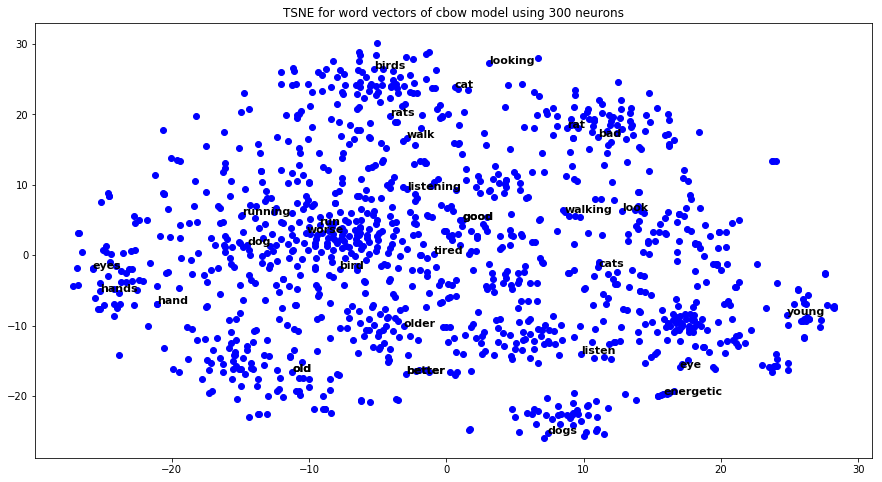

In [14]:
# CBOW model with 300 neurons
tsne = TSNE(n_components=2, init='pca', random_state=0)
cbow_300neurons_model_vectors_projection = tsne.fit_transform(cbow_300neurons_embeddings).T
fig = plt.figure(figsize=(15, 8))
plt.scatter(cbow_300neurons_model_vectors_projection[0],
            cbow_300neurons_model_vectors_projection[1],
            c='b', cmap=plt.cm.Spectral)

for word in analogy_words_to_visualize:
    idx = tokenizer.word_index[word]
    x_pos= cbow_300neurons_model_vectors_projection[0][idx]
    y_pos= cbow_300neurons_model_vectors_projection[1][idx]
    plt.annotate(word, (x_pos, y_pos), fontsize=11, fontweight='bold')

plt.title("TSNE for word vectors of cbow model using 300 neurons")
plt.show()

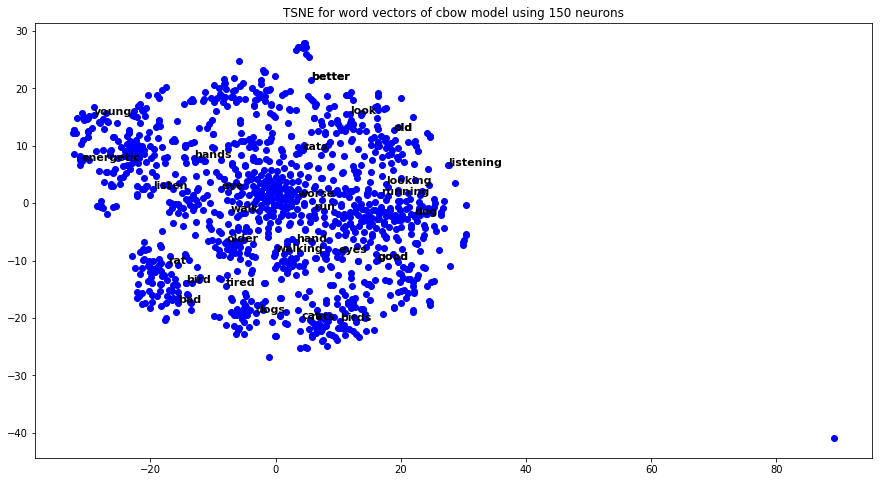

In [59]:
# CBOW model with 150 neurons
tsne = TSNE(n_components=2, init='pca', random_state=0)
cbow_150neurons_model_vectors_projection = tsne.fit_transform(cbow_150neurons_embeddings).T
fig = plt.figure(figsize=(15, 8))
plt.scatter(cbow_150neurons_model_vectors_projection[0],
            cbow_150neurons_model_vectors_projection[1],
            c='b', cmap=plt.cm.Spectral)

for word in analogy_words_to_visualize:
    idx = tokenizer.word_index[word]
    x_pos= cbow_150neurons_model_vectors_projection[0][idx]
    y_pos= cbow_150neurons_model_vectors_projection[1][idx]
    plt.annotate(word, (x_pos, y_pos), fontsize=11, fontweight='bold')

plt.title("TSNE for word vectors of cbow model using 150 neurons")
plt.show()

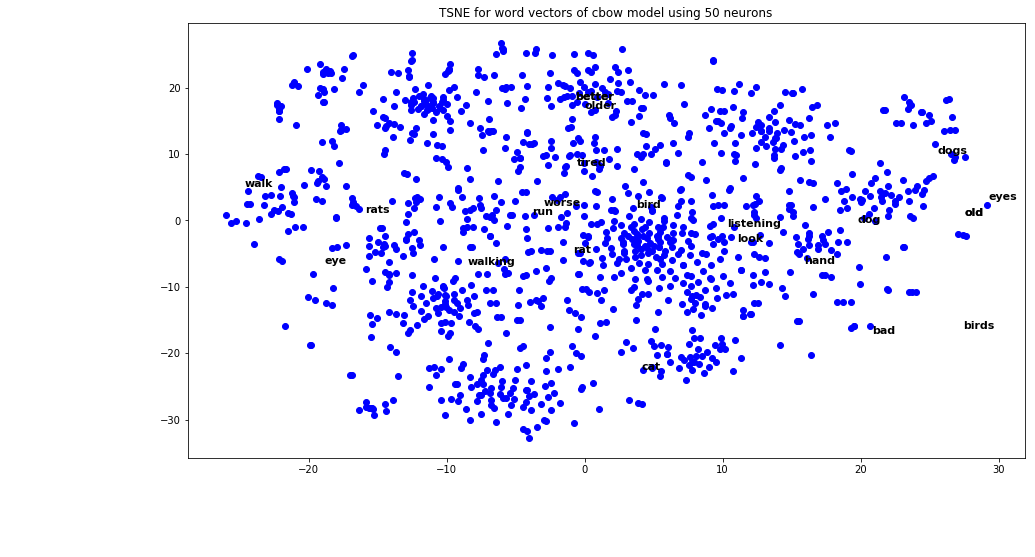

In [60]:
# CBOW model with 50 neurons
tsne = TSNE(n_components=2, init='pca', random_state=0)
cbow_50neurons_model_vectors_projection = tsne.fit_transform(cbow_50neurons_embeddings).T
fig = plt.figure(figsize=(15, 8))
plt.scatter(cbow_300neurons_model_vectors_projection[0],
            cbow_300neurons_model_vectors_projection[1],
            c='b', cmap=plt.cm.Spectral)

for word in analogy_words_to_visualize:
    idx = tokenizer.word_index[word]
    x_pos= cbow_50neurons_model_vectors_projection[0][idx]
    y_pos= cbow_50neurons_model_vectors_projection[1][idx]
    plt.annotate(word, (x_pos, y_pos), fontsize=11, fontweight='bold')

plt.title("TSNE for word vectors of cbow model using 50 neurons")
plt.show()

#### Visualization of Skipgram models

The next two figures show the TSNE representation of some of the words used in the analogy task for two skipgram models:
* skipgram model with 300 neurons in the representation layer
* modified skipgram model with 300 neurons in the representation layer
    
These two models correspond to the best and worst skipgram models according to the analogy task.

In [50]:
analogy_words_to_visualize = ['bad', 'worse', 'good', 'better',
                            'listen', 'listening', 'look', 'looking',
                            'bird', 'birds', 'cat', 'cats',
                            'good', 'better', 'old', 'older',
                            'dog', 'dogs', 'eye', 'eyes',
                            'hand', 'hands', 'rat', 'rats',
                            'run', 'running', 'walk', 'walking',
                            'young', 'energetic', 'old', 'tired']


In [51]:
# skipgram model with 150 neurons
tsne = TSNE(n_components=2, init='pca', random_state=0)
skipgram_300neurons_model_vectors_projection = tsne.fit_transform(skipgram_300neurons_model_vectors).T
print("skipgram 150 neurons vectors projection computed")

# skipgram model with 150 neurons
tsne = TSNE(n_components=2, init='pca', random_state=0)
skipgram_150neurons_modified_model_vectors_projection = tsne.fit_transform(skipgram_150neurons_modified_model_vectors).T
print("skipgram 150 neurons modified model vectors projection computed")


skipgram 150 neurons vectors projection computed
skipgram 150 neurons modified model vectors projection computed


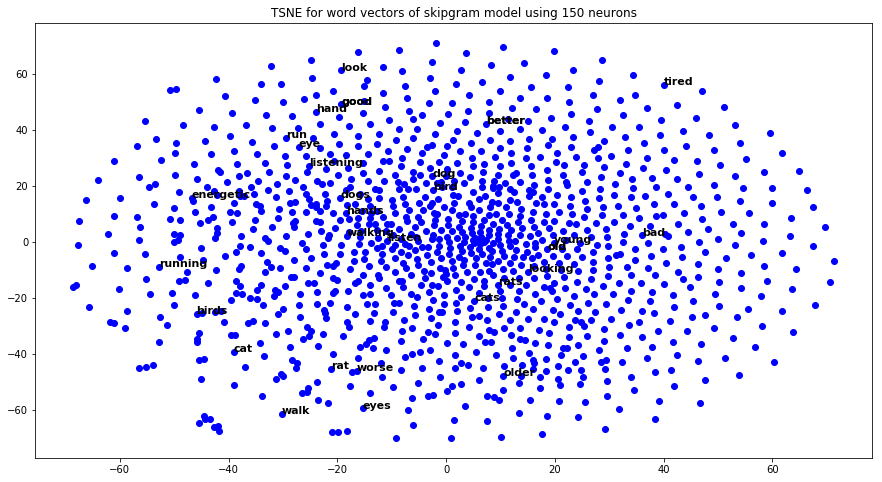

In [52]:
fig = plt.figure(figsize=(15, 8))
plt.scatter(skipgram_300neurons_model_vectors_projection[0],
            skipgram_300neurons_model_vectors_projection[1],
            c='b', cmap=plt.cm.Spectral)

for word in analogy_words_to_visualize:
    idx = tokenizer.word_index[word]
    x_pos= skipgram_300neurons_model_vectors_projection[0][idx]
    y_pos= skipgram_300neurons_model_vectors_projection[1][idx]
    plt.annotate(word, (x_pos, y_pos), fontsize=11, fontweight='bold')

plt.title("TSNE for word vectors of skipgram model using 150 neurons")
plt.show()

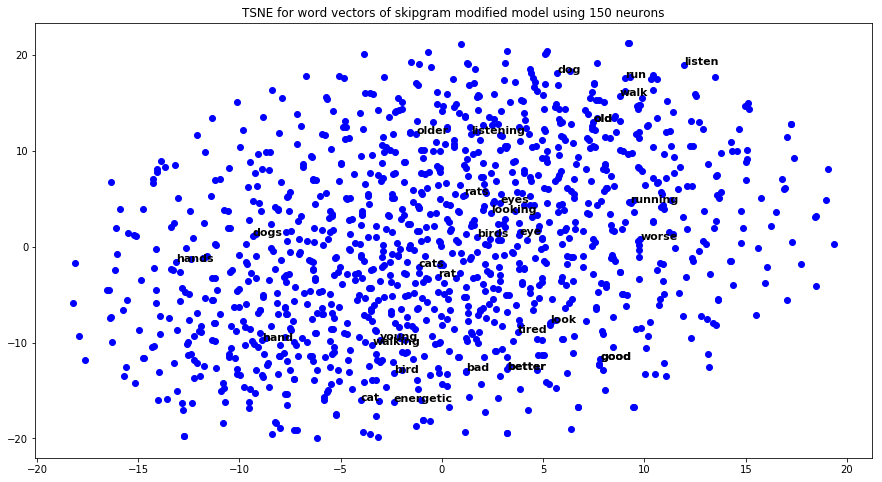

In [53]:
fig = plt.figure(figsize=(15, 8))
plt.scatter(skipgram_150neurons_modified_model_vectors_projection[0],
            skipgram_150neurons_modified_model_vectors_projection[1],
            c='b', cmap=plt.cm.Spectral)

for word in analogy_words_to_visualize:
    idx = tokenizer.word_index[word]
    x_pos= skipgram_150neurons_modified_model_vectors_projection[0][idx]
    y_pos= skipgram_150neurons_modified_model_vectors_projection[1][idx]
    plt.annotate(word, (x_pos, y_pos), fontsize=11, fontweight='bold')

plt.title("TSNE for word vectors of skipgram modified model using 150 neurons")
plt.show()

### Interpretation results of the visualization

#### Visualizations for Skipgram models

From the visualizations we observe that some words with similar meanings are grouped together:

* Listen and listening, bird and birds, and walking and running in the first visualization for skipgram
* Eye and ayes in the second visualization for skipgram

But we cannot observe clear clusters of words in both visualizations. This could be due to the small dataset used to create the word embeddings. With a larger dataset we could expect to obtain more information from the TSNE projections.

#### Visualizations for CBOW models

From the visualizations of the CBOW models with respectively 150 and 50 neurons it can be observed that:

* In the visualization with 50 and 300 neurons clusters can be seen more clearly than in the visualization with 150 neurons.
* The CBOW with 150 neuron clusters words together like 'young' and 'energetic' which in some context have the same meaning, but also words which belong to the same type like the animals 'rats' and 'birds'. In the visualization of CBOW with 50 neuros this is not visible, in the visualization with 300 neurons it is visible but not as well as with 150 neurons

From this we can conclude that the CBOW with 150 neurons gives the best result on our data set. However with more or less neurons the clusters are better visible, the results with 150 neurons places similar words closer together.


## 2.5 Using the word-word co-occurrence matrix from question 1. Compare the results of the trained word embeddings with the word-word co-occurrence matrix

In [54]:
# train nn model for the co-occurrence matrix
nn_coMatrix = nn(n_neighbors=21, algorithm='brute', metric='cosine').fit(coMatrix)

# compute analogy precision
analogies_results["co-occurrence"] = analogy_precision(analogies, coMatrix,nn_coMatrix)


In [55]:
print("Precision for co-occurrence vectors: {:3f}".format(analogies_results["co-occurrence"]))


Precision for co-occurrence vectors: 0.023256


### Results 

The precision value for the co-ocurrence vectors on the analogies are worse than each word embedding created using the basic skipgram model. Because the modified skipgram models gives overall worse results than the basic skipgram model, we don't use those results to compare the performance of the co-ocurrence vectors.

Hence, the co-ocurrence vectors need more memory and seem to perform worse than the skipgram models. It seems like this simple model should be avoided if possible.



## 2.6 Discussion of the advantages of CBOW and Skipgram, the advantages of negative sampling and drawbacks of CBOW and Skipgram

### Advantages of CBOW
While using CBOW for this assignment the following advantages appeared:
* CBOW is relatively fast, much faster than skipgram for the same dataset with the same amount of neurons.
* Based on the context a wordt can be predicted quite accurately
* By choosing different window sizes context can be considered less or more important

### Advantages of Skipgram
Next we present advantages of word embeddings created using Skipgram:
* They are able to encode similarity using the words that appear close to them in the corpus. 
* Their length is a parameter that can be tuned to get good results in relevant tasks.
* The space needed to store them is way smaller than the one needed to store co-occurrence vectors.
* When properly constructed they are able to capture relational meanings between words. For example, they can be used to compute analogies.

### Advantages of negative sampling

The definition of the cost function for CBOW and Skipgram involves computations over the entire vocabulary in order to update the parameters of the weight matrix corresponding to a word embedding. This computation is very expensive, and it has to be done for all the word embeddings for a given number of epochs in order to obtain the final values for the word embeddings. Negative solves this problem by selecting a small number of non-related words (negative examples) for each word embedding. This words and the context words are used to compute a modified cost function that allow us to update the parameters of each word embedding much faster than using the previous method. Hence, negative sampling is a method to compute word embeddings in a fast way. 

### Drawbacks of CBOW
Despite the advantages of CBOW there are some drawbacks:
* Because CBOW is training on the context of a word a lot of data is needed to accurately predict a word contained by the context.
* Rare words are never predicted: because CBOW chooses the most probable word given a training set rare words are never outputted by cbow, which can be quite dangerous if the training set is not good sampled.


### Drawbacks of Skipgram
Next we present some drawbacks of the skipgram model:
* As mentioned before, the computation of the basic Skipgram model takes too much time, but this issue is solved by using negative sampling. 
* Because the Skipgram is based on neural network architectures there is a large number of parameters that have to be tunned in order to get good word embeddings. 
* The quality of the word embeddings is related to the amount of data used to train the neural networks.
* We can only use the word embeddings for the words that exist in the vocabulary used to construct them.

## 2.7 Evaluation using pre-trained embedding on large corpora of GloVe and Word2vec

Due to problems loading the datasets for both embeddings, this section was not done.

In [142]:
#load pretrained word embeddings of word2vec

path_word2vec = "GoogleNews-vectors-negative300.bin"

google = KeyedVectors.load_word2vec_format(path_word2vec, binary=True)
google_alice_words = [w for w in tokenizer.word_index if w in google]
google_vectors = [google[w] for w in google_alice_words]
print("Done")

Done


In [139]:
#load pretraind word embeddings of Glove

path = "glove.6B.300d_converted.txt"

#convert GloVe into word2vec format
#vector = gensim.scripts.glove2word2vec.get_glove_info(path)
#gensim.scripts.glove2word2vec.glove2word2vec(path, "glove_converted.txt")

glove = KeyedVectors.load_word2vec_format(path, binary=False)
glove_alice_words = [w for w in tokenizer.word_index if w in glove]
glove_vectors = [glove[w] for w in glove_alice_words]
print("Done")

Done


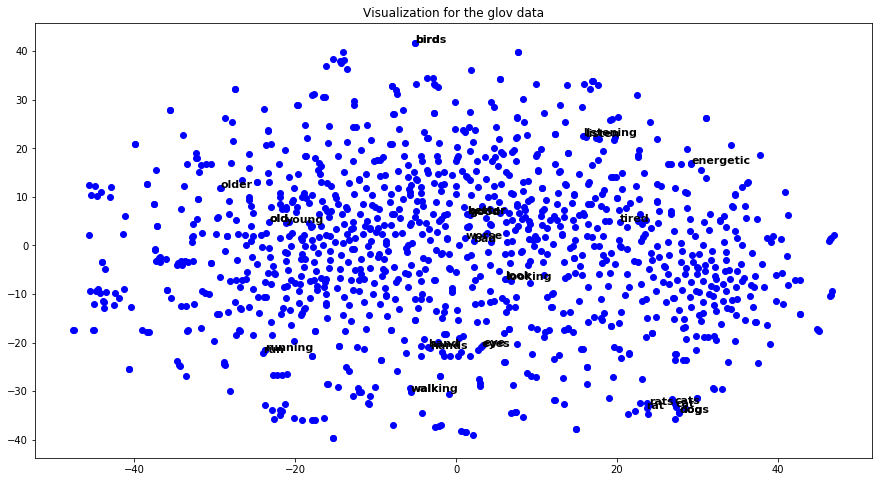

In [140]:
# Apply TSNE to the glov vectors
tsne = TSNE(n_components=2, init='pca', random_state=0)

glove_vectors_projection = tsne.fit_transform(glove_vectors).T

#Visualize the pre-trained word embeddings
fig = plt.figure(figsize=(15, 8))
plt.scatter(glove_vectors_projection[0],
            glove_vectors_projection[1],
            c='b', cmap=plt.cm.Spectral)

for word in analogy_words_to_visualize:
    x_pos = glove_vectors_projection[0][glove_alice_words.index(word)]
    y_pos = glove_vectors_projection[1][glove_alice_words.index(word)]
    plt.annotate(word, (x_pos, y_pos), fontsize=11, fontweight='bold')

plt.title("Visualization for the glov data")
plt.show()

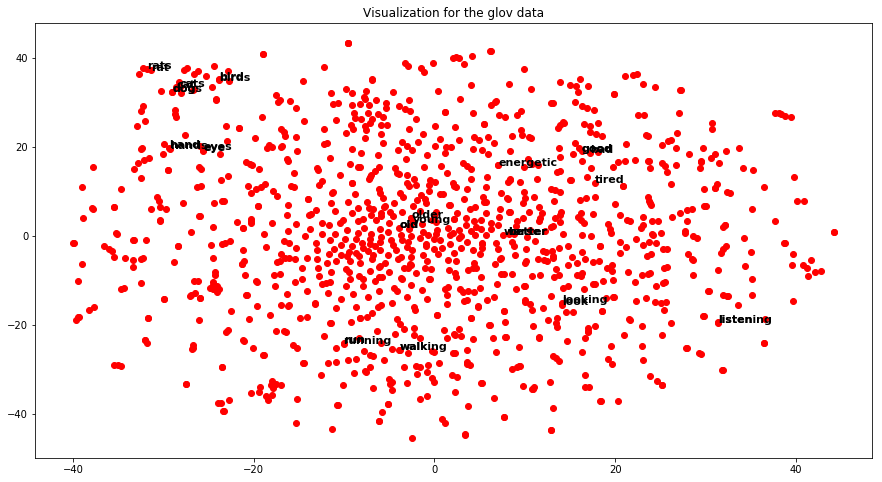

In [143]:
# Apply TSNE to the google vectors
tsne = TSNE(n_components=2, init='pca', random_state=0)

google_vectors_projection = tsne.fit_transform(google_vectors).T

#Visualize the pre-trained word embeddings
fig = plt.figure(figsize=(15, 8))
plt.scatter(google_vectors_projection[0],
            google_vectors_projection[1],
            c='r', cmap=plt.cm.Spectral)

for idx, word in enumerate(analogy_words_to_visualize):
    x_pos= google_vectors_projection[0][google_alice_words.index(word)]
    y_pos= google_vectors_projection[1][google_alice_words.index(word)]
    plt.annotate(word, (x_pos, y_pos), fontsize=11, fontweight='bold')

plt.title("Visualization for the glov data")
plt.show()

### Similarity between the anology words based on the glove data

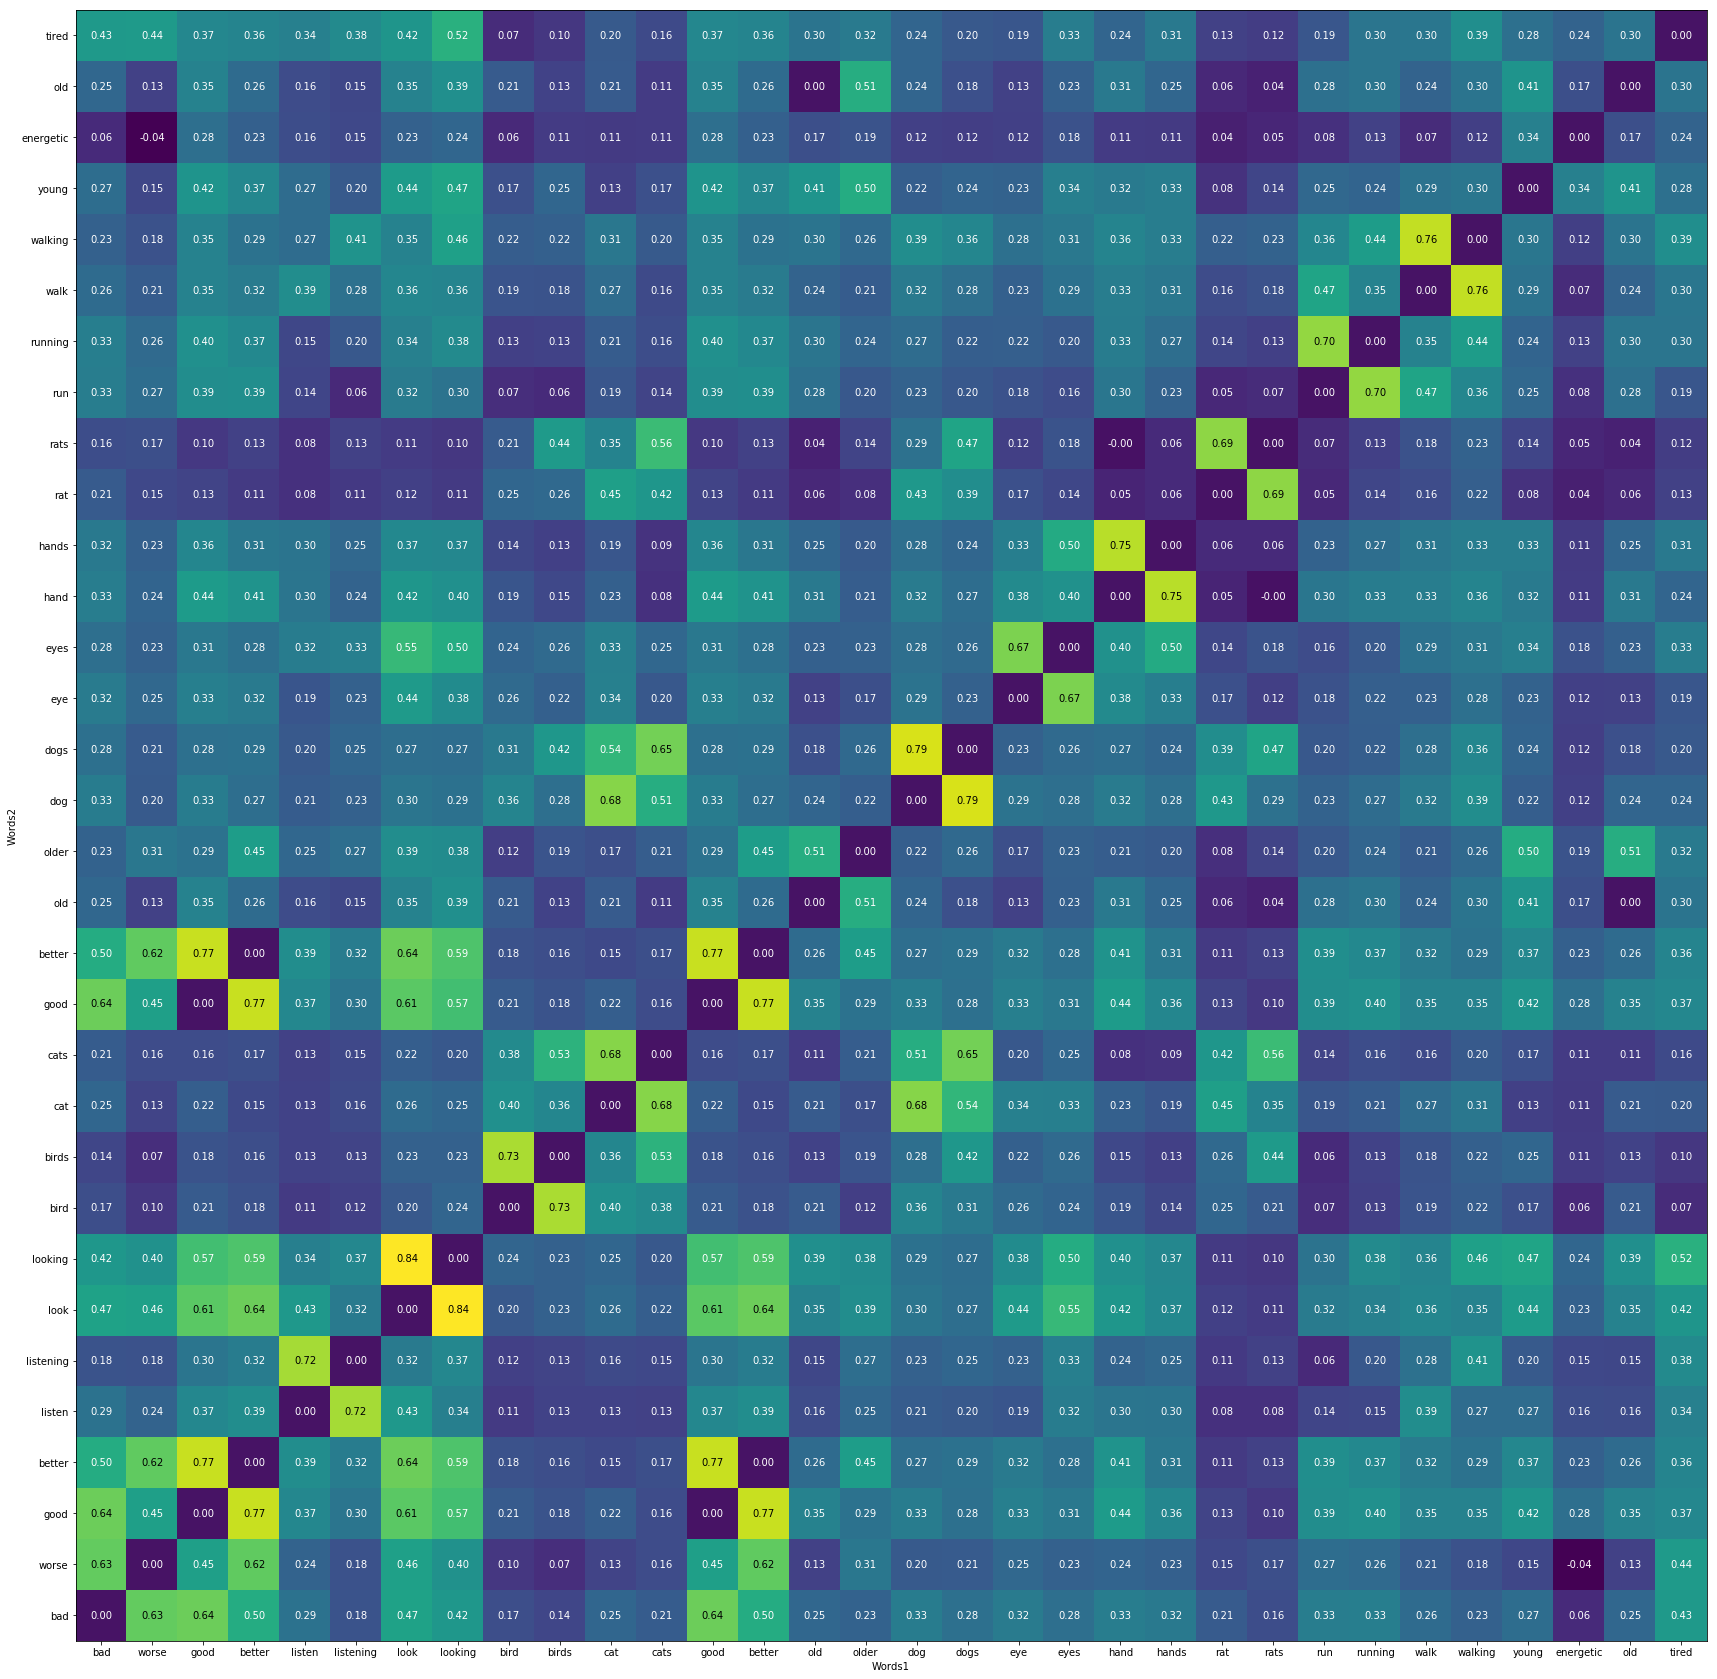

In [129]:
import mglearn

similarity_matrix = np.array([])
for word1 in analogy_words_to_visualize:
    for word2 in analogy_words_to_visualize:
        if word1 == word2:
            similarity_matrix = np.append(similarity_matrix, 0)
            continue
        similarity_matrix = np.append(similarity_matrix, glove.similarity(word1, word2))
similarity_matrix = np.reshape(similarity_matrix, (len(analogy_words_to_visualize), len(analogy_words_to_visualize)))

plt.figure(figsize=(30, 30))
mglearn.tools.heatmap(similarity_matrix, xlabel='Words1', xticklabels=analogy_words_to_visualize,
                      ylabel='Words2', yticklabels=analogy_words_to_visualize, cmap="viridis");
plt.show()

Comparison performance with your own trained word embeddings

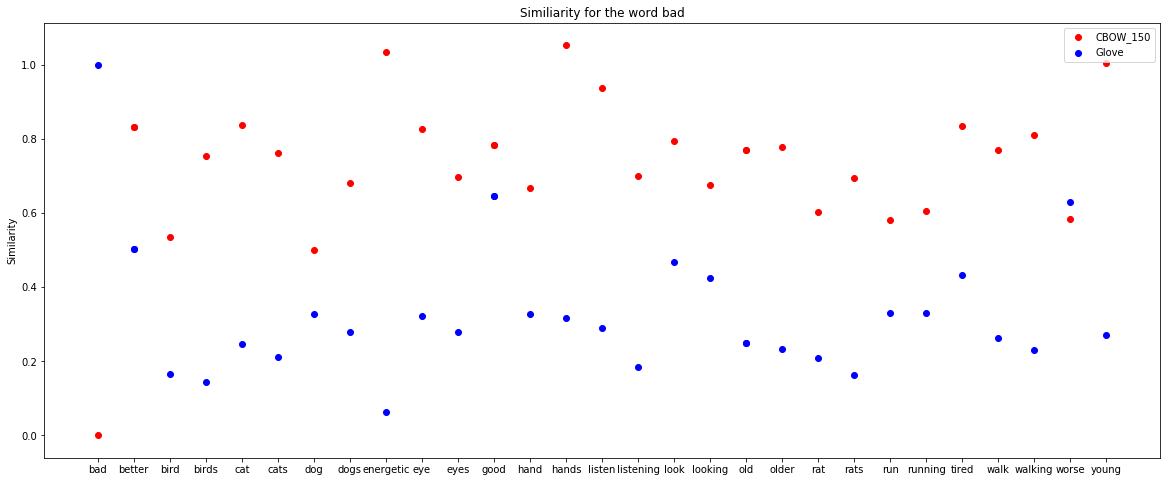

In [131]:
from scipy.spatial.distance import cosine

for word1 in analogy_words_to_visualize:
    cbow_accuracy, glove_accuracy = np.array([]), np.array([])
    for word2 in analogy_words_to_visualize:
        glove_accuracy = np.append(glove_accuracy, glove.similarity(word1, word2))
        idx1 = tokenizer.word_index[word1]
        idx2 = tokenizer.word_index[word2]
        cbow_word1 = cbow_300neurons_embeddings[idx1]
        cbow_word2 = cbow_300neurons_embeddings[idx2]
        cbow_accuracy = np.append(cbow_accuracy, cosine(cbow_word1, cbow_word2))
    
    plt.figure(figsize=(20, 8))
    plt.scatter(analogy_words_to_visualize, cbow_accuracy, label="CBOW_150", c='r')
    plt.scatter(analogy_words_to_visualize, glove_accuracy, label="Glove", c='b')
    plt.ylabel('Similarity')
    plt.legend()
    plt.title("Similiarity for the word {}".format(word1))
    plt.show()
    break
        

In [146]:
from itertools import chain

def glove_is_valid_analogy(word1, word2, word3, target, glove, nnmodel, words):
    if not all(w in glove for w in [word1, word2, word3, target])

    vector_w1 = glove[word1]
    vector_w2 = glove[word2]
    vector_w3 = glove[word3]
    composed_vector = vector_w1 - vector_w2 + vector_w3
    distances, indices = nnmodel.kneighbors(composed_vector.reshape(1, -1))
    return words.index(target) in indices

def glove_analogy_precision(analogies, glove, nnmodel, words):
    correct = 0
    total = 0
    for analogy in analogies:
        if glove_is_valid_analogy(analogy[0], analogy[1], analogy[2], analogy[3], glove, nnmodel, words):
            correct += 1
        total += 1
    return correct/(total*1.0)

nn_glove = nn(n_neighbors=21, algorithm='brute', metric='cosine').fit(glove_vectors)
result_glove = glove_analogy_precision(analogies, glove, nn_glove, glove_alice_words)
nn_google = nn(n_neighbors=21, algorithm='brute', metric='cosine').fit(google_vectors)
result_google = glove_analogy_precision(analogies, google, nn_google, google_alice_words)

print("Precision for analogies in the glove dataset: {:3f}".format(result_glove))
print("Precision for analogies in the google dataset: {:3f}".format(result_google))

print("Precision for word vectors of 50x1 using cbow model: {:3f}".format(analogies_results["cbow_50n"]))
print("Precision for word vectors of 150x1 using cbow model: {:3f}".format(analogies_results["cbow_150n"]))
print("Precision for word vectors of 300x1 using cbow model: {:3f}".format(analogies_results["cbow_300n"]))

print("Precision for word vectors of 50x1 using cbow + dense model: {:3f}".format(analogies_results["cbow_50n_dense"]))
print("Precision for word vectors of 150x1 using cbow + dense model: {:3f}".format(analogies_results["cbow_150n_dense"]))
print("Precision for word vectors of 300x1 using cbow + dense model: {:3f}".format(analogies_results["cbow_300n_dense"]))


KeyError: "word 'dinah' not in vocabulary"